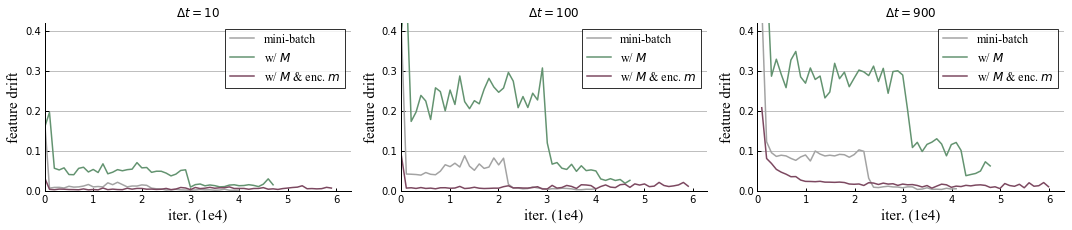

In [58]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import numpy as np
import matplotlib.pyplot as plt


class TBReader:
    def __init__(self, tbfile, data_count):
        COMPRESSED_HISTOGRAMS = 'distributions'
        HISTOGRAMS = 'histograms'
        IMAGES = 'images'
        AUDIO = 'audio'
        SCALARS = 'scalars'
        TENSORS = 'tensors'
        GRAPH = 'graph'
        META_GRAPH = 'meta_graph'
        RUN_METADATA = 'run_metadata'
        sg = {
            COMPRESSED_HISTOGRAMS: data_count,
            IMAGES: 4,
            AUDIO: 4,
            SCALARS: data_count,
            HISTOGRAMS: data_count,
            TENSORS: 10,
        }
        self.tb = EventAccumulator(tbfile, size_guidance=sg).Reload()

    def get_scalar(self, key):
        scalar = self.tb.Scalars(key)
        return [x.step for x in scalar], [x.value for x in scalar]

    def get_hist(self, key):
        hist = self.tb.Histograms(key)
        return hist

def get_line(log_file, keys):
    tblog = TBReader(log_file, 100000)
    ret = list()
    for k in keys:
        hist = tblog.get_hist(k)
        ret.append(np.array([[x.step, x.histogram_value.sum / x.histogram_value.num] for x in hist]))
    return ret

moco_k = r'w/ $M$ & enc. $m$'
xbm_k = r'w/ $M$'
batch_k = r'mini-batch'

def get_all_lines():
    log_file = '/opt/FTE/users/haozhang/code/mml/tblog/compare_mem2/sop_go_we_ma_contrastive_contrastive_lr0.0001_m0.0_margin0.5_te20.0_st1000/events.out.tfevents.1590031887.mg12'
    xbm_lines_10, xbm_lines_100, xbm_lines_900 = get_line(log_file, ['drift_10', 'drift_100', 'drift_900'])
    log_file = '/opt/FTE/users/haozhang/code/mml/tblog/compare_mem2/sop_go_we_ma_contrastive_contrastive_lr0.0003_m0.999_margin0.5_te20.0_st-1/events.out.tfevents.1590031414.mg10'
    moco_lines_10, moco_lines_100, moco_lines_900 = get_line(log_file, ['drift_10', 'drift_100', 'drift_900'])

    log_file = '/opt/FTE/users/haozhang/code/mml/tblog/compare_mem2/sop_go_we_ma_contrastive_contrastive_lr0.0001_m0.0_margin0.5_te20.0_st1000000/events.out.tfevents.1590031414.mg10'
    batch_lines_10, batch_lines_100, batch_lines_900 = get_line(log_file, ['drift_10', 'drift_100', 'drift_900'])

    return {
        r'$\Delta t=10$': {moco_k: moco_lines_10, xbm_k: xbm_lines_10, batch_k: batch_lines_10},
        r'$\Delta t=100$': {moco_k: moco_lines_100, xbm_k: xbm_lines_100, batch_k: batch_lines_100},
        r'$\Delta t=900$': {moco_k: moco_lines_900, xbm_k: xbm_lines_900, batch_k: batch_lines_900}
    }


def draw(figs_data):
    font = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 15,
        }

    legend_font = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 12,
        }
    color = {
        xbm_k: (99/255, 147/255, 112/255),
        moco_k: (124/255, 72/255, 96/255),
        batch_k: (163/255, 163/255, 163/255),
        
    }
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 3.3), sharex=True)

    
    for ax, fig_name, fig_data in zip(axs, figs_data.keys(), figs_data.values()):
        sequence = [batch_k, xbm_k, moco_k]
        for label in sequence:
            line = fig_data[label]
            ax.plot(line[:, 0], line[:, 1], label=label, color=color[label])

        ax.legend(prop = legend_font, edgecolor=(0, 0, 0), fancybox=False)
        ax.set_title(fig_name)
        
        # ax.xticks([1, 10000, 20000, 30000, 40000, 50000, 60000], ['0', '1', '2', '3', '4', '5', '6'])
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_linewidth(1);###设置底部坐标轴的粗细
        ax.spines['left'].set_linewidth(1);####设置左边坐标轴的粗细
        ax.tick_params(direction='in', width=1)
        ax.grid(axis="y")
        ax.set_xlabel("iter. (1e4)", fontdict=font)
        ax.set_ylabel('feature drift', fontdict=font)
        ax.set_xlim(0, 63000)
        ax.set_ylim(0, 0.42)
        
    plt.xticks([1, 10000, 20000, 30000, 40000, 50000, 60000], ['0', '1', '2', '3', '4', '5', '6'])
    fig.tight_layout()
    plt.savefig('compare_feature_drift.pdf')
    plt.show()
lines = get_all_lines()
draw(lines)